In [1]:
from astropy.table import Table
import astropy.cosmology as cosmo
import matplotlib.pyplot as plt
import bilby
import numpy as np
import healpy as hp
import pandas as pd

In [2]:
catalog = Table.read('data/catalog_fullsky_zsm1.fits.gz').to_pandas()

In [3]:
ra = catalog['RA'].values
dec = catalog['DEC'].values
z = catalog['REDSHIFT'].values

mask = (z<0.08) & (ra>0) & (ra<360) & (np.abs(dec)<90)
# z=0.08 -> dl=365Mpc
# z=0.2 -> dl=1000Mpc

ra = ra[mask] * np.pi / 180
dec = dec[mask] * np.pi / 180
z = z[mask]

cosmology = cosmo.WMAP7
bilby.gw.cosmology.set_cosmology(cosmology=cosmology)

dl = bilby.gw.conversion.redshift_to_luminosity_distance(z)

100%%


setting the output map dtype to [dtype('float64')]


HEALPix Map written to file


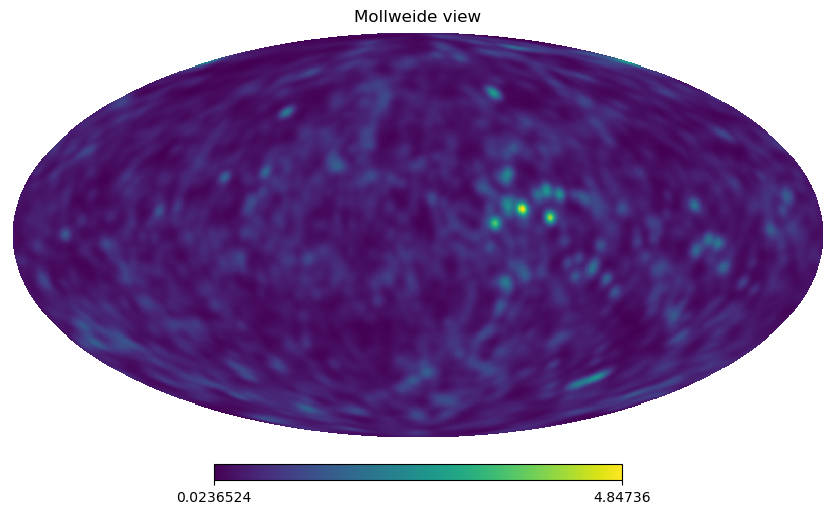

In [4]:
NSIDE = 2**10
NPIX = hp.nside2npix(NSIDE)
hp_map = np.zeros(NPIX)

size = 0.03

for i in range(len(z)):
    hp_map[hp.pixelfunc.ang2pix(NSIDE, 0.5 * np.pi - dec[i], ra[i])] += 1e7*dl[i]**(-2)
    if not i % 100:
        print("\r{}".format(np.round(100*(i+1)/len(z), 1)), end="%")

print("\r100%")

hp_map = hp.sphtfunc.smoothing(hp_map, sigma=size)

hp.fitsfunc.write_map('data/catalog_skymap.fits', hp_map, overwrite=True)
print("HEALPix Map written to file")

hp.mollview(hp_map)

In [6]:
masses = np.random.uniform(25,35,2)
index = np.random.randint(0, len(z))
sindist = bilby.core.prior.Sine()
cosdist = bilby.core.prior.Cosine()

injectp = dict(mass_1=np.max(masses),
                            mass_2=np.min(masses),
                            a_1=np.random.uniform(0, 0.99),
                            a_2=np.random.uniform(0, 0.99),
                            tilt_1=sindist.sample(),
                            tilt_2=sindist.sample(),
                            phi_12=np.random.uniform(0, 2*np.pi),
                            phi_jl=np.random.uniform(0, 2*np.pi),
                            luminosity_distance=dl[index],
                            theta_jn=sindist.sample(),
                            psi=np.random.uniform(0, np.pi),
                            phase=np.random.uniform(0, 2*np.pi),
                            geocent_time=np.random.uniform(1.1e9, 1.2e9),
                            ra=ra[index],
                            dec=dec[index]
                           )

injectp

{'mass_1': 29.477616108757427,
 'mass_2': 27.598626625751955,
 'a_1': 0.259066602541997,
 'a_2': 0.9666782783529614,
 'tilt_1': 0.9778566195311853,
 'tilt_2': 1.8815552468133612,
 'phi_12': 1.888450139908128,
 'phi_jl': 2.0717149244257196,
 'luminosity_distance': 870.0858828704525,
 'theta_jn': 0.35679256121238456,
 'psi': 0.2644195857468533,
 'phase': 0.18800518105444525,
 'geocent_time': 1112446314.626581,
 'ra': 4.51357,
 'dec': 0.5419434}

In [10]:
sim_results = pd.DataFrame({
    'index':[],
    'id':[],
    'mass_1':[],
    'mass_2':[],
    'a_1':[],
    'a_2':[],
    'tilt_1':[],
    'tilt_2':[],
    'phi_12':[],
    'phi_jl':[],
    'luminosity_distance':[],
    'theta_jn':[],
    'psi':[],
    'phase':[],
    'geocent_time':[],
    'ra':[],
    'dec':[],
    'un_dl_med':[],
    'un_dl_upper':[],
    'un_dl_lower':[],
    'un_dl_avg':[],
    'un_dl_std':[],
    'un_ra_med':[],
    'un_ra_upper':[],
    'un_ra_lower':[],
    'un_ra_avg':[],
    'un_ra_std':[],
    'un_dec_med':[],
    'un_dec_upper':[],
    'un_dec_lower':[],
    'un_dec_avg':[],
    'un_dec_std':[],
    'hp_dl_med':[],
    'hp_dl_upper':[],
    'hp_dl_lower':[],
    'hp_dl_avg':[],
    'hp_dl_std':[],
    'hp_ra_med':[],
    'hp_ra_upper':[],
    'hp_ra_lower':[],
    'hp_ra_avg':[],
    'hp_ra_std':[],
    'hp_dec_med':[],
    'hp_dec_upper':[],
    'hp_dec_lower':[],
    'hp_dec_avg':[],
    'hp_dec_std':[],
})

#sim_results.to_csv('data/sim_results.csv')

In [2]:
results = pd.read_csv('data/sim_results.csv')
results

,index,id,mass_1,mass_2,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,...,hp_ra_med,hp_ra_upper,hp_ra_lower,hp_ra_avg,hp_ra_std,hp_dec_med,hp_dec_upper,hp_dec_lower,hp_dec_avg,hp_dec_std
0,365528.0,HL1,30.217311,29.438553,0.751386,0.677525,0.419540,0.947159,5.605048,0.169506,...,4.005878,4.017005,3.993372,4.005418,0.010660,-0.800903,-0.794875,-0.802514,-0.798930,0.005455
1,350362.0,HL2,34.192054,25.832763,0.734118,0.828593,2.379955,1.929529,4.589761,5.187325,...,3.563003,3.688673,3.442073,3.565794,0.140527,-1.029397,-0.958668,-1.112838,-1.026672,0.084489
2,253902.0,HL3,29.564056,27.715090,0.421830,0.589163,2.213256,1.515623,4.043051,4.685177,...,1.626752,1.697199,1.584618,1.633538,0.034478,-0.272865,-0.254085,-0.299447,-0.272945,0.013680
3,103531.0,HL4,32.027256,31.191251,0.257114,0.872378,0.654759,0.672897,3.845300,6.121425,...,2.195107,2.322213,2.058417,2.185717,0.092768,-0.926509,-0.812048,-1.069103,-0.934926,0.089602
4,15598.0,HL5,33.899337,30.139870,0.664454,0.374693,2.566352,1.534428,1.485206,0.408078,...,0.699185,0.920030,0.549302,0.713148,0.118182,0.253450,0.537333,-0.112704,0.232516,0.221768
5,182589.0,HL6,28.331563,25.632695,0.376191,0.394249,1.226196,1.084364,2.251962,1.343527,...,5.494907,5.573728,5.476862,5.502887,0.028959,-0.886847,-0.840073,-0.890568,-0.881573,0.015768
6,15841.0,HL7,31.594252,26.222984,0.409206,0.074227,1.606865,2.625892,5.068744,0.638779,...,1.145248,1.217405,1.076483,1.159494,0.228591,0.278660,0.367713,0.221479,0.286279,0.074931
7,127207.0,HL8,33.422959,28.810489,0.485959,0.749672,0.877906,0.563864,0.464355,0.675797,...,4.908494,4.957901,4.856632,4.909118,0.032360,0.063867,0.127606,0.017027,0.068704,0.032005
8,230216.0,HL9,28.824755,26.393321,0.624373,0.667193,1.133969,1.309301,4.668446,2.957800,...,3.119051,3.197252,3.063847,3.123056,0.041498,-0.994216,-0.932933,-1.076890,-1.008863,0.049023
9,338523.0,HL0_lite_test,30.874261,26.130978,0.181567,0.576493,1.320009,1.052885,3.098742,5.994654,...,3.482201,3.503196,3.461934,3.482358,0.012637,-0.837683,-0.836718,-0.838632,-0.837801,0.002740


In [3]:
event_id = results['id'].values
true_dl = results['luminosity_distance'].values
uniform_md = results['un_dl_med'].values
uniform_hi = results['un_dl_upper'].values
uniform_lo = results['un_dl_lower'].values
uniform_avg = results['un_dl_avg'].values
uniform_std = results['un_dl_std'].values
healpix_md = results['hp_dl_med'].values
healpix_hi = results['hp_dl_upper'].values
healpix_lo = results['hp_dl_lower'].values
healpix_avg = results['hp_dl_avg'].values
healpix_std = results['hp_dl_std'].values

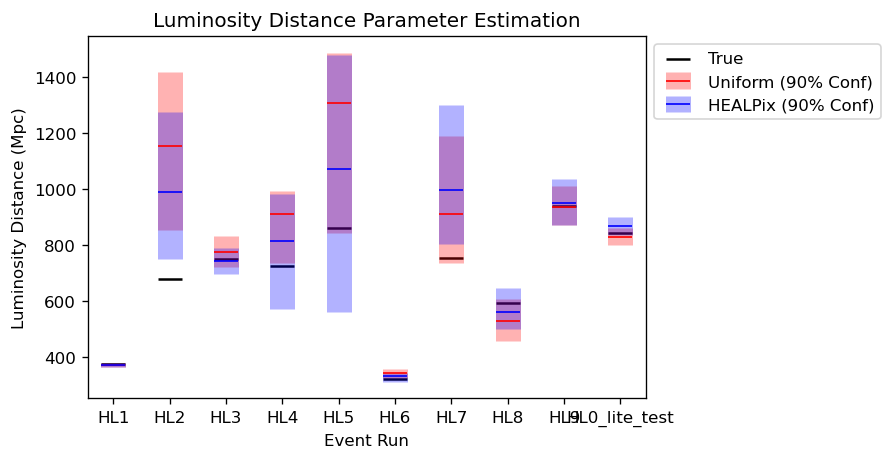

In [4]:
fig, ax = plt.subplots()
fig.set_dpi(120)
uni_error = [np.abs(uniform_md-uniform_lo), np.abs(uniform_md-uniform_hi)]
hp_error = [np.abs(healpix_md-healpix_lo), np.abs(healpix_md-healpix_hi)]
mark, caps, bars = ax.errorbar(event_id, uniform_md, yerr=uni_error, fmt='_', color='red', elinewidth=15, ms=14, label='Uniform (90% Conf)')
[bar.set_alpha(0.3) for bar in bars]
[cap.set_alpha(0.3) for cap in caps]
mark, caps, bars = ax.errorbar(event_id, healpix_md, yerr=hp_error, fmt='_', color='blue', elinewidth=15, ms=14, label='HEALPix (90% Conf)')
[bar.set_alpha(0.3) for bar in bars]
[cap.set_alpha(0.3) for cap in caps]
ax.scatter(event_id, true_dl, color='k', marker='_', s=196, label='True')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Luminosity Distance Parameter Estimation')
ax.set_xlabel('Event Run')
ax.set_ylabel('Luminosity Distance (Mpc)')
#ax.set_ylim([300,500])
plt.show()

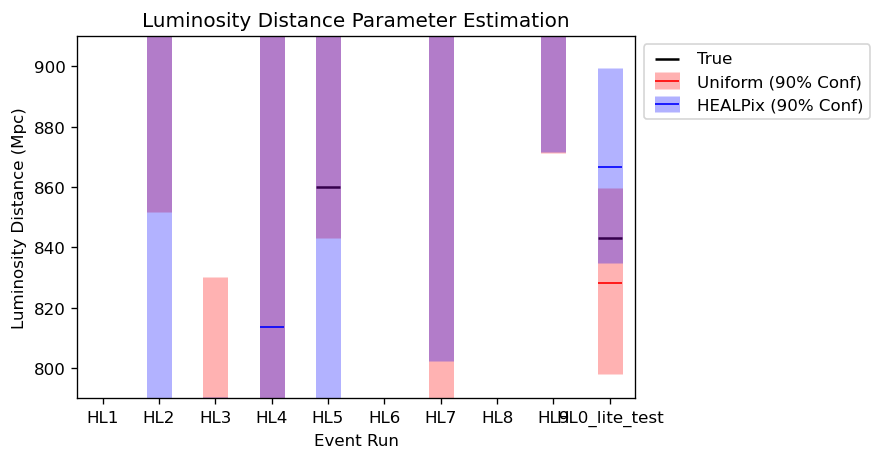

In [9]:
fig, ax = plt.subplots()
fig.set_dpi(120)
uni_error = [np.abs(uniform_md-uniform_lo), np.abs(uniform_md-uniform_hi)]
hp_error = [np.abs(healpix_md-healpix_lo), np.abs(healpix_md-healpix_hi)]
mark, caps, bars = ax.errorbar(event_id, uniform_md, yerr=uni_error, fmt='_', color='red', elinewidth=15, ms=14, label='Uniform (90% Conf)')
[bar.set_alpha(0.3) for bar in bars]
[cap.set_alpha(0.3) for cap in caps]
mark, caps, bars = ax.errorbar(event_id, healpix_md, yerr=hp_error, fmt='_', color='blue', elinewidth=15, ms=14, label='HEALPix (90% Conf)')
[bar.set_alpha(0.3) for bar in bars]
[cap.set_alpha(0.3) for cap in caps]
ax.scatter(event_id, true_dl, color='k', marker='_', s=196, label='True')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Luminosity Distance Parameter Estimation')
ax.set_xlabel('Event Run')
ax.set_ylabel('Luminosity Distance (Mpc)')
ax.set_ylim([790,910])
plt.show()

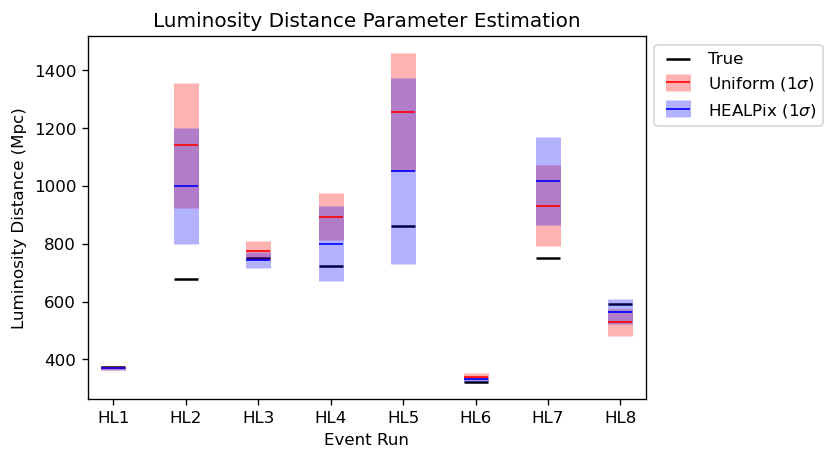

In [17]:
fig, ax = plt.subplots()
fig.set_dpi(120)
uni_error = uniform_std
hp_error = healpix_std
mark, caps, bars = ax.errorbar(event_id, uniform_avg, yerr=uni_error, fmt='_', color='red', elinewidth=15, ms=14, label='Uniform ($1\sigma$)')
[bar.set_alpha(0.3) for bar in bars]
[cap.set_alpha(0.3) for cap in caps]
mark, caps, bars = ax.errorbar(event_id, healpix_avg, yerr=hp_error, fmt='_', color='blue', elinewidth=15, ms=14, label='HEALPix ($1\sigma$)')
[bar.set_alpha(0.3) for bar in bars]
[cap.set_alpha(0.3) for cap in caps]
ax.scatter(event_id, true_dl, color='k', marker='_', s=196, label='True')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Luminosity Distance Parameter Estimation')
ax.set_xlabel('Event Run')
ax.set_ylabel('Luminosity Distance (Mpc)')
#ax.set_ylim([300,500])
plt.show()

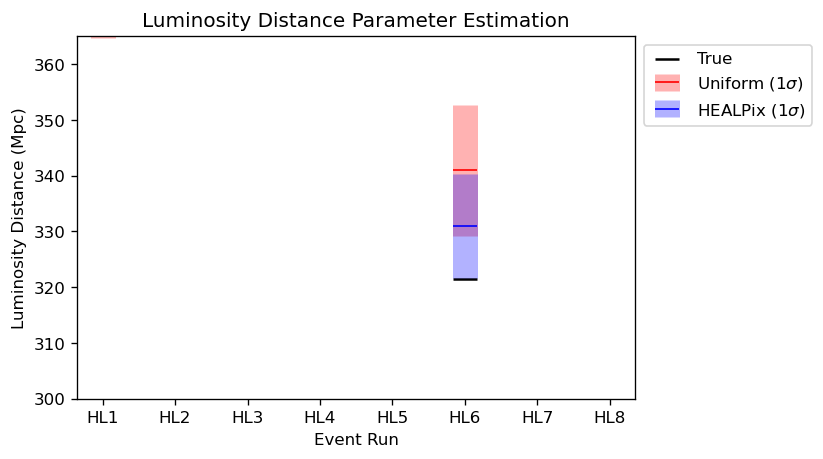

In [18]:
fig, ax = plt.subplots()
fig.set_dpi(120)
uni_error = uniform_std
hp_error = healpix_std
mark, caps, bars = ax.errorbar(event_id, uniform_avg, yerr=uni_error, fmt='_', color='red', elinewidth=15, ms=14, label='Uniform ($1\sigma$)')
[bar.set_alpha(0.3) for bar in bars]
[cap.set_alpha(0.3) for cap in caps]
mark, caps, bars = ax.errorbar(event_id, healpix_avg, yerr=hp_error, fmt='_', color='blue', elinewidth=15, ms=14, label='HEALPix ($1\sigma$)')
[bar.set_alpha(0.3) for bar in bars]
[cap.set_alpha(0.3) for cap in caps]
ax.scatter(event_id, true_dl, color='k', marker='_', s=196, label='True')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Luminosity Distance Parameter Estimation')
ax.set_xlabel('Event Run')
ax.set_ylabel('Luminosity Distance (Mpc)')
ax.set_ylim([300,365])
plt.show()